## English/French Translator:Sequence-to-Sequence

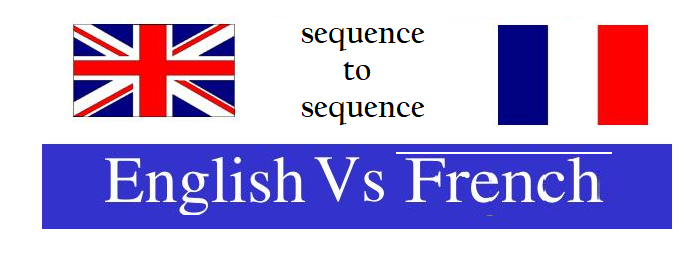

In [1]:
from collections import Counter
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
# Logging
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
df_english = pd.read_csv("/content/drive/MyDrive/small_vocab_en.csv",sep = '\t' , names = ['english'])
df_french = pd.read_csv("/content/drive/MyDrive/small_vocab_fr.csv",sep = '\t' , names = ['french'])

In [3]:
print("df_english info :- ",df_english.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
df_english info :-  None


In [4]:
print("df_french info :- ",df_french.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   french  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
df_french info :-  None


In [5]:
df = pd.concat([df_english,df_french],1)

In [6]:
df.head()

,english,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


## take some of data

In [7]:
df=df.sample(n=35000)

### shape of data

In [8]:
print("Total English records : ", df.english.shape[0])
print("Total French records : ", df.french.shape[0])

Total English records :  35000
Total French records :  35000


### Remove punctuation

In [9]:
import string
def msg_clean(msg):
    clean =  [(char) for char in msg if char not in string.punctuation]
    clean = "".join(clean)
    return clean

In [10]:
df['french'] = df['french'].apply(msg_clean)

In [11]:
df['english'] = df['english'].apply(msg_clean)

In [12]:
df['english'].head()

90022                   he likes oranges and strawberries 
65471    paris is usually nice during september  and it...
86035    new jersey is usually dry during december  but...
86151    france is chilly during december  and it is us...
46063           she dislikes lemons  peaches  and mangoes 
Name: english, dtype: object

## DATA CLEANING

## split data into train & test

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['english'].tolist(), df['french'].tolist(), test_size=0.2, random_state=42)

In [ ]:
print("\nsample senetnce in English Language : ",X_train[5])
print("french Language : ",y_train[5])


sample senetnce in English Language :  india is usually warm during march  and it is sometimes snowy in september 
french Language :  l inde est habituellement chaud en mars  et il est parfois enneigée en septembre 


In [14]:
def preprocess(seq):         
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' 
    for ele in seq: 
        if ele in punc: 
            seq = seq.replace(ele, "") 
    line = seq.split()
    line = [word.lower() for word in line]
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    line = [re_print.sub('', w) for w in line]
    return " ".join(line)

In [15]:
english_sentences = []          
french_sentences = []         
french_sentences_inputs = []

In [16]:
for i in range(len(X_train)):
    input_sentence = preprocess(X_train[i])
    output = y_train[i]
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    english_sentences.append(input_sentence)
    french_sentences.append(output_sentence)
    french_sentences_inputs.append(output_sentence_input)

In [17]:
print("Number of English samples :", len(english_sentences))
print("Number of output samples:", len(french_sentences))
print("Number of input output samples:", len(french_sentences_inputs))

Number of English samples : 28000
Number of output samples: 28000
Number of input output samples: 28000


In [18]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
total_input = english_sentences +  [preprocess(line) for line in X_test]
max_input_len = max([len(txt.split()) for txt in total_input])

In [21]:
print("Max length for input : : ",max_input_len)

Max length for input : :  15


In [23]:
print("Max length for output:",max([len(txt.split()) for txt in french_sentences]))

Max length for output: 20


In [24]:
unique_input_tokens = set()
for line in total_input:
    words = line.split()
    for word in words:
        unique_input_tokens.add(word)
print("Unique tokens for inputs : ",len(unique_input_tokens))

Unique tokens for inputs :  199


In [26]:
unique_output_tokens = set()
for line in french_sentences:
    words = line.split()
    for word in words:
        unique_output_tokens.add(word)
print("Unique tokens for outputs : ",len(unique_output_tokens))

Unique tokens for outputs :  331


In [28]:
# last 2 sentences of preprocessed text
print("\nLast 2 sentences of preprocessed text")
for inpu,outpu in zip(english_sentences[-2:],french_sentences[-2:]):
  print(inpu,"   -->   ",outpu)


Last 2 sentences of preprocessed text
you like peaches bananas and mangoes    -->    vous aimez les pêches  les bananes et les mangues  <eos>
our least liked fruit is the grapefruit but their least liked is the mango    -->    notre moins aimé des fruits est le pamplemousse  mais leur moins aimé est la mangue  <eos>


## Tokenization

In [32]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(total_input)

In [34]:
input_integer_seq = input_tokenizer.texts_to_sequences(english_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

Total unique words in the input: 199


In [36]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Length of longest sentence in input: 15


In [37]:
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(french_sentences + french_sentences_inputs)

In [38]:
output_integer_seq = output_tokenizer.texts_to_sequences(french_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(french_sentences_inputs)

In [39]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 331


In [41]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 20


## Paadding 

In [43]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

encoder_input_sequences.shape: (28000, 15)
encoder_input_sequences[0]: [ 0  5 20 21  1 67  4 52  7  3  1  9 65  2 57]


In [44]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post') 
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

decoder_input_sequences.shape: (28000, 20)
decoder_input_sequences[0]: [ 5  6 31  1 67  2 55  8  3  1 11 59  2 54  0  0  0  0  0  0]


### 

In [45]:
glove_vector=dict()
file=open('/content/drive/MyDrive/glove.6B.200d.txt',encoding='utf-8')

for line in file:
  values=line.split()
  word=values[0]
  vectors=np.asarray(values[1:])
  glove_vector[word]=vectors
file.close()

In [46]:
word_vector_matrix=np.zeros((len(word2idx_inputs) + 1,200))

for word,index in word2idx_inputs.items():
  vector=glove_vector.get(word)
  if vector is not None:
    word_vector_matrix[index]=vector
    
  else:
    print(word)

In [48]:
decoder_targets_one_hot = np.zeros((len(english_sentences),max_out_len,num_words_output),dtype='float32')
print(decoder_targets_one_hot.shape)


(28000, 20, 332)


In [50]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [55]:
# Encoder
LSTM_NODES =128
BATCH_SIZE = 16
EPOCHS = 10
LSTM_NODES =128

embedding_layer = Embedding(len(word2idx_inputs) + 1, 200, weights=[word_vector_matrix], input_length=max_input_len)
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [56]:
# Decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [57]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 200)      40000       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 128)      42496       input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [58]:
history = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1,)

Epoch 1/10
1575/1575 [==============================] - 15s 8ms/step - loss: 0.9146 - accuracy: 0.7598 - val_loss: 0.3887 - val_accuracy: 0.8895
Epoch 2/10
1575/1575 [==============================] - 12s 7ms/step - loss: 0.2328 - accuracy: 0.9405 - val_loss: 0.1297 - val_accuracy: 0.9712
Epoch 3/10
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0947 - accuracy: 0.9779 - val_loss: 0.0761 - val_accuracy: 0.9818
Epoch 4/10
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0623 - accuracy: 0.9846 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 5/10
1575/1575 [==============================] - 12s 7ms/step - loss: 0.0486 - accuracy: 0.9876 - val_loss: 0.0502 - val_accuracy: 0.9865
Epoch 6/10
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0407 - accuracy: 0.9897 - val_loss: 0.0424 - val_accuracy: 0.9887
Epoch 7/10
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0346 - accuracy: 0.9913 - val_loss: 0.0397 - val_ac

## save our model 

In [59]:
model.save('seq2seq_source_target.h5')

## Plotting the accuracy and loss graphs

In [60]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label=' training data')
    plt.plot(history.history['val_accuracy'], 'ro--' ,label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label=' training data')
    plt.plot(history.history['val_loss'],'ro--' , label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

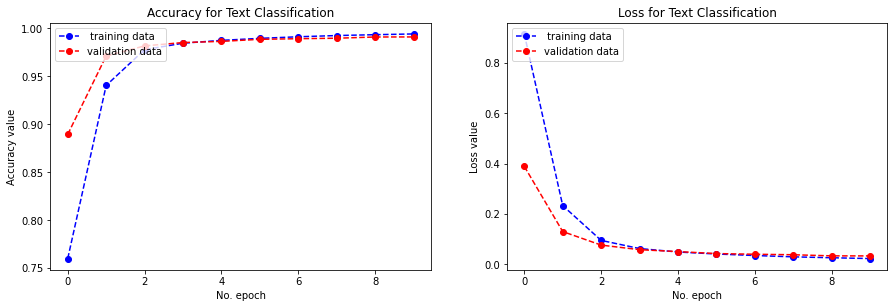

In [61]:
plot_accuracy_loss(history)

In [62]:
# Prediction
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [63]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [64]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [65]:
# Dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [66]:
# utility function for inference phase
def inference(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [69]:

# Testing on few random samples
for _ in range(10):
    i = np.random.choice(len(english_sentences))
    eng_sen = encoder_input_sequences[i:i+1]
    translation = inference(eng_sen)
    print('*********************************************')
    print('English: {}'.format(english_sentences[i]))
    print('Prediction: {}'.format(translation))
    print('Ground truth: {}'.format(french_sentences[i]))

*********************************************
English: i like bananas grapefruit and grapes
Prediction: jaime les bananes le pamplemousse et les raisins
Ground truth: jaime les bananes  le pamplemousse et les raisins  <eos>
*********************************************
English: his least favorite fruit is the grape but their least favorite is the mango
Prediction: son fruit préféré est moins le raisin mais leur moins préféré est la mangue
Ground truth: son fruit préféré est moins le raisin  mais leur moins préféré est la mangue  <eos>
*********************************************
English: china is usually snowy during march but it is sometimes quiet in september
Prediction: la chine est généralement enneigée en mars mais il est parfois calme en septembre
Ground truth: la chine est généralement enneigée en mars  mais il est parfois calme en septembre  <eos>
*********************************************
English: california is sometimes nice during autumn but it is sometimes wonderful in 

In [70]:
# Automatic evaluation with the BLEU metric
def encode_to_input(s):
    s = preprocess(s)
    x  = []
    for w in s.split():
        x.append(word2idx_inputs[w.lower()])
    return pad_sequences([x], maxlen=max_input_len)

In [73]:
from nltk.translate.bleu_score import sentence_bleu

In [74]:
# Calculating average BLEU score on test set (2000 size in our case)
def evaluate_model(X,Y):
    count = 0
    total_score = 0
    for x,y in zip(X,Y):
        encoded_x = encode_to_input(x)
        translated_x =inference(encoded_x)
        reference = [y.split()]
        candidate = translated_x.split()
        blue_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        count = count +1
        total_score = total_score + blue_score
        if count%100==0:
          print(count,blue_score,total_score,x,y)
    return total_score/count

In [75]:
average_score = evaluate_model(X_test,y_test)
print("Average BLEU score",average_score)

100 1.0 97.97490931236737 we like apples  peaches  and limes  nous aimons les pommes  les pêches et les citrons verts 
200 1.0 195.52261010036116 your least liked fruit is the grapefruit  but their least liked is the apple  votre moins aimé des fruits est le pamplemousse  mais leur moins aimé est la pomme 
300 0.7054014374088451 291.9814252208349 he likes that rusty blue automobile  il aime que l automobile bleu rouillé 
400 1.0 389.7738729476793 new jersey is hot during winter  but it is busy in november  new jersey est chaud pendant l hiver  mais il est occupé en novembre 
500 0.4953587998572467 486.73379688262247 peaches are her least liked fruit  les pêches sont moins elle aimait les fruits 
600 1.0 584.7213653044089 china is usually quiet during march  but it is chilly in october  chine est généralement calme au mois de mars  mais il est froid en octobre 
700 1.0 682.344888857301 china is never rainy during june  but it is never chilly in november  chine est jamais pluvieux en jui